In [76]:
import json
import time
import glob
import math
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy.stats import moment
from itertools import permutations
from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import clear_output


In [2]:
timeout = 120
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.cumsum(np.random.exponential(scale=1/LAMBDA, size=(a,)))
            ps = np.clip(np.random.normal(MU, SIGMA, size=(a,)), a_min=0, a_max=None)
            ds = [r + VARK*moment(ps, moment=2) for r in rs]
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale_r(self, alpha):
        self.array[:,0] = self.array[:,0]*alpha
        return self


In [21]:
def find_local_best(s, sortedTasks, unsortedTasks):
    
    def find_L_max(task):
        pi = sortedTasks + [task]
        return s[pi].L_max()

    return min(unsortedTasks, key=find_L_max)

In [15]:
s = TaskSet(4)

In [16]:
find_local_best(s, [2, 1], [0, 3])

3

In [19]:
s[[2,1,3]].L_max()

-420.6385182388667

In [170]:
# m is the num of machines
def greedy_Lmax(s, m):
    bestLmax = float('inf')
    piArray = [[] for i in range(m)]
    unsortedTasks = [i for i in range(len(s))]
    
    for i in range(len(s)):
        localPiArray = copy.deepcopy(piArray)
        bestLmax = float('inf')
        for j in range(m):
            sortedTasks = piArray[j]
            bestTask = find_local_best(s, sortedTasks, unsortedTasks)
            localPiArray[j] += [bestTask]
            currLmax = s[localPiArray[j]].L_max()
            if currLmax < bestLmax:
                bestLmax = currLmax
                bestj = j
                globalBestTask = bestTask
        piArray[bestj] += [globalBestTask]
        unsortedTasks.remove(globalBestTask)
    return bestLmax, piArray

In [167]:
def greedy_r(s, m):
    bestLmax = float('inf')
    piArray = [[] for i in range(m)]
    unsortedTasks = [i for i in range(len(s))]
    for i in unsortedTasks:
        localPiArray = copy.deepcopy(piArray)
        bestLmax = float('inf')
        for j in range(m):
            localPiArray[j].append(i)
            Lmax = s[localPiArray[j]].L_max()
            if Lmax < bestLmax:
                bestLmax = Lmax
                bestj = j
        piArray[bestj].append(i)
    return max([s[pi].L_max() for pi in piArray if len(pi) > 0]), piArray

In [97]:
def bruteforce(s):
    bestPi1 = []
    bestPi2 = []
    pi = [i for i in range(len(s))]
    bestLmax = float('inf')
    for perm in permutations(pi):
        for i in range(len(s)+1):
            pi1 = perm[:i]
            pi2 = perm[i:]
            #print(pi1, pi2)
            if len(pi1) == 0:
                tLmax = s[list(pi2)].L_max()
            elif len(pi2) == 0:
                tLmax = s[list(pi1)].L_max()
            else:
                tLmax = max(s[list(pi1)].L_max(), s[list(pi2)].L_max())
            if tLmax < bestLmax:
                bestLmax = tLmax
                bestPi1 = list(pi1).copy()
                bestPi2 = list(pi2).copy()
    return bestLmax, bestPi1, bestPi2

In [162]:
s = TaskSet(5)

In [168]:
greedy_r(s, 5)

(-2224.398582959249, [[0, 1, 2], [3], [4], [], []])

In [169]:
bruteforce(s)

(-2224.398582959249, [0, 1, 2], [3, 4])

In [140]:
s[[4]].L_max()

-66.23166945950607

In [174]:
def brute_test(func, N_TASKS=100):
    results = []
    pBar = IntProgress(min=0, max=N_TASKS)
    display(pBar)
    for i in range(N_TASKS):
        s = TaskSet(5)
        gL = func(s, 2)[0]
        bL = bruteforce(s)[0]
        if gL < bL:
            #print("Smth wrong with bruteforce")
            raise RuntimeError("Smth wrong with bruteforce")
        results.append((gL - bL)/np.abs(bL)*100)
        pBar.value += 1
    return pd.DataFrame([[max(results), min(results), np.mean(results)]], columns=["Максимум отклонения, %", "Минимум отклонения, %", "Среднее отклонение, %"])


In [175]:
brute_test(greedy_Lmax)

IntProgress(value=0)

,"Максимум отклонения, %","Минимум отклонения, %","Среднее отклонение, %"
0,1839.977821,0.0,100.120743


In [176]:
brute_test(greedy_r)

IntProgress(value=0)

,"Максимум отклонения, %","Минимум отклонения, %","Среднее отклонение, %"
0,6.467389,0.0,0.197566


In [ ]:
#alphaRange = remove(np.arange(0, 2, 0.1), 1.)
alphaRange = np.arange(0, 2.1, 0.1)

N_TASKS = 10
allResults = []
prgBar = IntProgress(min = 0, max = N_TASKS)
display(prgBar)
for n in range(N_TASKS):
    scaledSchedules = []
    s = TaskSet(10)
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    
    pointResults = []
    s1, s2 = flattenedScaledSchedules[:2]
    for s in flattenedScaledSchedules[2:]:
        linearEqResults = []
        for index, x1 in enumerate(s1):
            x2 = s2[index]
            x = s[index]
            if x2 != x1: linearEqResults.append(linear_equation(x, x1, x2))
        pointResults.append(np.all(np.isclose(linearEqResults, linearEqResults[0])))
    allResults.append(np.all(pointResults))
    prgBar.value += 1

IntProgress(value=0, max=10)

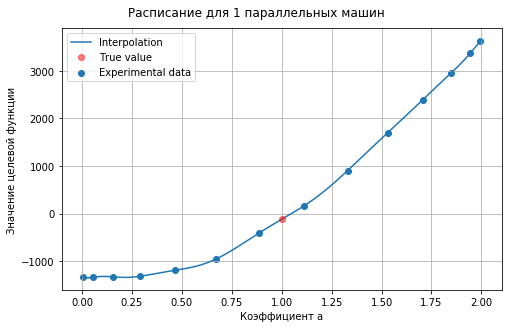

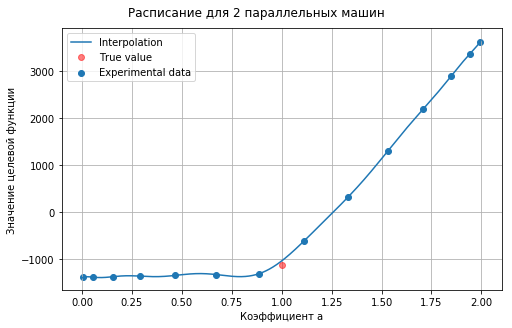

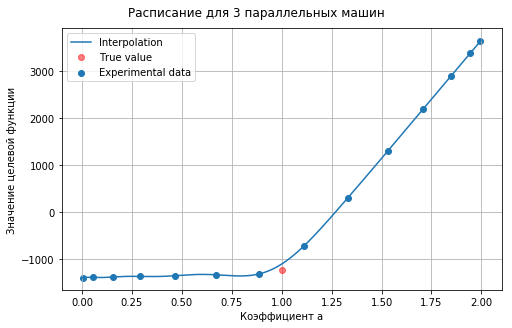

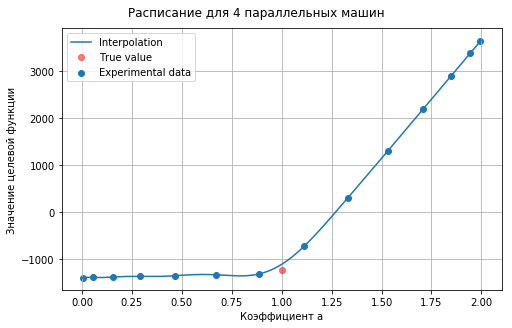

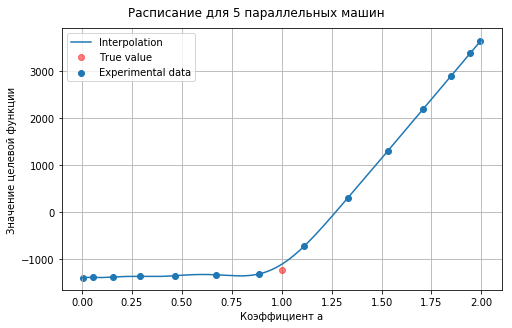

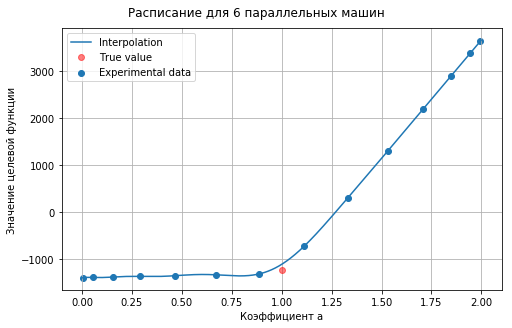

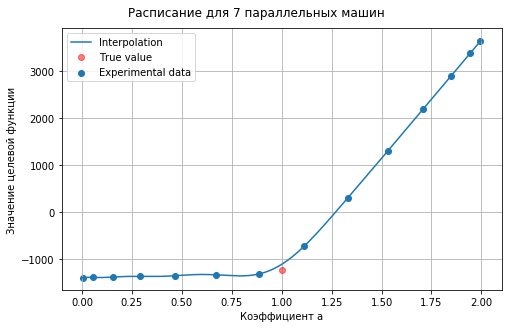

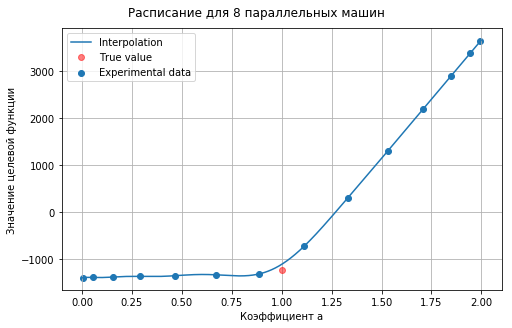

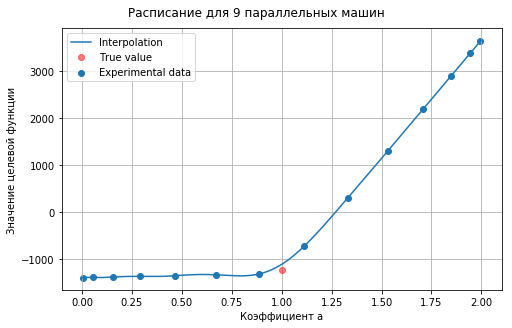

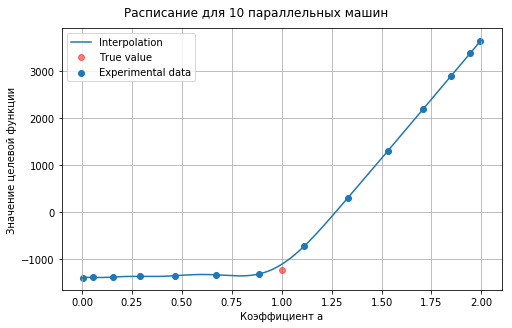

In [183]:
global realResult
global approxResults
global m
global s
s = TaskSet(50)

def test_schedule(alpha_arr):
    global approxResults
    global realResult
    global m
    global s
    approxResults = []
    for a in alpha_arr:
        #print("\ra =", a, end='')
        scaled_s = s.copy().scale_r(a)
        #flattenedScaled_s = list(map(lambda x: x.array.flatten(), scaled_s))
        Lmax = greedy_r(scaled_s, m)[0]
        approxResults.append((a, Lmax))
    realResult = (1., greedy_r(s, m)[0])
    approxResults = np.array(approxResults)
    return approxResults[:,1]

N_TASKS = 10
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
for i in range(N_TASKS):
    m = i + 1
    C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
    approxResults = np.array(approxResults)
    
    x = approxResults[:,0]
    y = approxResults[:,1]
    xp = np.arange(0, 2, 0.001)
    yp = C(xp)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
    fig.suptitle("Расписание для %s параллельных машин" % m)
    axes.scatter(x, y, label="Experimental data")
    axes.plot(xp, yp, label="Interpolation")
    axes.grid()
    axes.set_xlabel("Коэффициент а")
    axes.set_ylabel("Значение целевой функции")
    axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
    axes.legend()
    pBar.value += 1